# Unisolar Projet: EDA
---

This project is based on the **UNISOLAR** open dataset containing solar energy production and weather data in various locations of the La Trobe University, Victoria, Australia, stored in a time series format.

The goal of this project is to build a model able to forecast energy production for the next 24 hours based on solar energy production and weather data of the last 7 days. Our model performance will be evaluated against a naive model predicting the value recorded 24 hours in the past.

This notebook goes through the EDA process and selection of a subset of data that will use for prediction the `unisolar_model.ipynb` notebook.  

## Imports

---


In [58]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fast')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from unisolar_utils import (plot_solar_generation_sites,
                            plot_weather_feature_campuses)           

## Datasets

---


The project contains three datasets:
- `Solar_Energy_Generation.csv`: Power generation for 42 sites split in 5 campus locations as a function of time.
- `Solar_Site_Details.csv`: Details of the different sites (number and type of solar panel, location, etc.)
- `Weather_Data_reordered_all.csv`: Weather data as a function of time at the different campus locations.

In [59]:
power_path = 'data/Solar_Energy_Generation.csv'
sites_path = 'data/Solar_Site_Details.csv'  #Won't be of any use for this stage of the project
weather_path = 'data/Weather_Data_reordered_all.csv'

## Exploratory Data Analysis: Solar Energy Generation

---

Let's start with the dataset containing our future target: the solar energy generation. We will also need some information contained in `Solar_Site_Details.csv`.

In [60]:
df_power = pd.read_csv(power_path, parse_dates=['Timestamp'])
df_power['CampusKey'] = df_power['CampusKey'].astype('int8')
df_power['SiteKey'] = df_power['SiteKey'].astype('int8')

df_sites = pd.read_csv(sites_path)

In [61]:
df_power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731946 entries, 0 to 2731945
Data columns (total 4 columns):
 #   Column           Dtype         
---  ------           -----         
 0   CampusKey        int8          
 1   SiteKey          int8          
 2   Timestamp        datetime64[ns]
 3   SolarGeneration  float64       
dtypes: datetime64[ns](1), float64(1), int8(2)
memory usage: 46.9 MB


In [62]:
df_power.head()

,CampusKey,SiteKey,Timestamp,SolarGeneration
0,2,1,2020-01-01 00:15:00,NaN
1,2,1,2020-01-01 00:30:00,NaN
2,2,1,2020-01-01 00:45:00,NaN
3,2,1,2020-01-01 01:00:00,NaN
4,2,1,2020-01-01 01:15:00,NaN


The dataset contains `SolarGeneration`` time series for each site of each campus.

In [63]:
df_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CampusKey         42 non-null     int64  
 1   SiteKey           42 non-null     int64  
 2   kWp               25 non-null     float64
 3   Number of panels  25 non-null     float64
 4   Panel             25 non-null     object 
 5   Inverter          25 non-null     object 
 6   Optimizers        23 non-null     object 
 7   Metric            25 non-null     object 
 8   lat               42 non-null     float64
 9   Lon               42 non-null     float64
dtypes: float64(4), int64(2), object(4)
memory usage: 3.4+ KB


In [64]:
print('Percent of missing date:\n', np.round(df_power.isna().sum()/len(df_power)*100), sep='')

Percent of missing date:
CampusKey           0.0
SiteKey             0.0
Timestamp           0.0
SolarGeneration    56.0
dtype: float64


In [65]:
print('Number of duplicated entries:', df_power.duplicated().sum())

Number of duplicated entries: 0


More than 55% of the `SolarGeneration` data are missing and there are no duplicated entires.

### Sites and campus
---

`SolarGeneration` data are recorded for 42 different sites, each located on different campuses. 
We create a series `sites_in_campus` containing the site numbers belonging to each different campus.

In [66]:
sites_in_campus = df_power.groupby('CampusKey')['SiteKey'].unique()
print(sites_in_campus)

CampusKey
1    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
2                                      [1, 2, 3, 4, 5]
3                         [6, 7, 8, 9, 10, 11, 12, 13]
4                                                 [41]
5                                                 [42]
Name: SiteKey, dtype: object


Campuses 1 the majority of sites, while campuses 4 and 5 only have on site each.

### Solar Generation Distribution Across Sites
---

Let's see how `SolarGeneration` compares between the different sites.

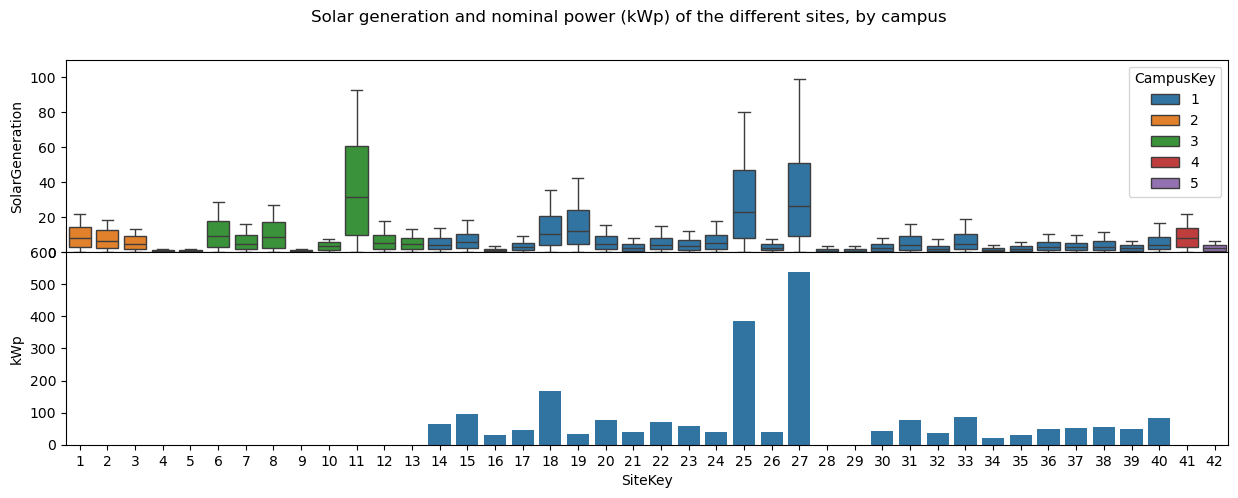

In [67]:
fig, axs = plt.subplots(2, 1, figsize = (15, 5), sharex=True)
sns.boxplot(df_power, x='SiteKey', y='SolarGeneration', hue='CampusKey', palette='tab10', ax=axs[0])
sns.barplot(df_sites, x='SiteKey', y='kWp', hue='CampusKey', palette='tab10', ax=axs[1], legend=False)
fig.suptitle('Solar generation and nominal power (kWp) of the different sites, by campus')
fig.subplots_adjust(hspace=0)
axs[0].set_ylim(0, 110)
axs[1].set_ylim(0, 600);

`SolarGeneration` varies significantly between sites. From the nominal power generation `kWp` (sum of nominal power of every panel in the site) for site 1 from the `df_sites` dataset, we see that different sites also have significantly different nominal power. This may account for most of the difference in power generation (but not all, as we can see when looking at sites number 18 and 19 for instance).


### Solar Generation Series
---

From now on, it will be more convenient to work with the pivoted dataframe:

In [68]:
df_power = df_power.pivot(index='Timestamp', columns='SiteKey', values='SolarGeneration')

In [69]:
df_power.head()

SiteKey,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have a common datetime index and 42 columns, one for each site. We lost the campus `CampusKey` information from the dataframe, but still have access to it through `sites_in_campus`.

We make sure `Timestamp`is sorted and fill in missing entries to have an evenly-spaced time series.

In [70]:
df_power.head().index.is_monotonic_increasing

True

In [71]:
time_series_idx = pd.pandas.date_range(min(df_power.index), max(df_power.index),freq='15min')
df_power = df_power.reindex(time_series_idx, fill_value=np.nan)
df_power.index.name = 'Timestamp'

We can now look at the individual `SolarGeneration` time series for each campus.

#### For Campus 1

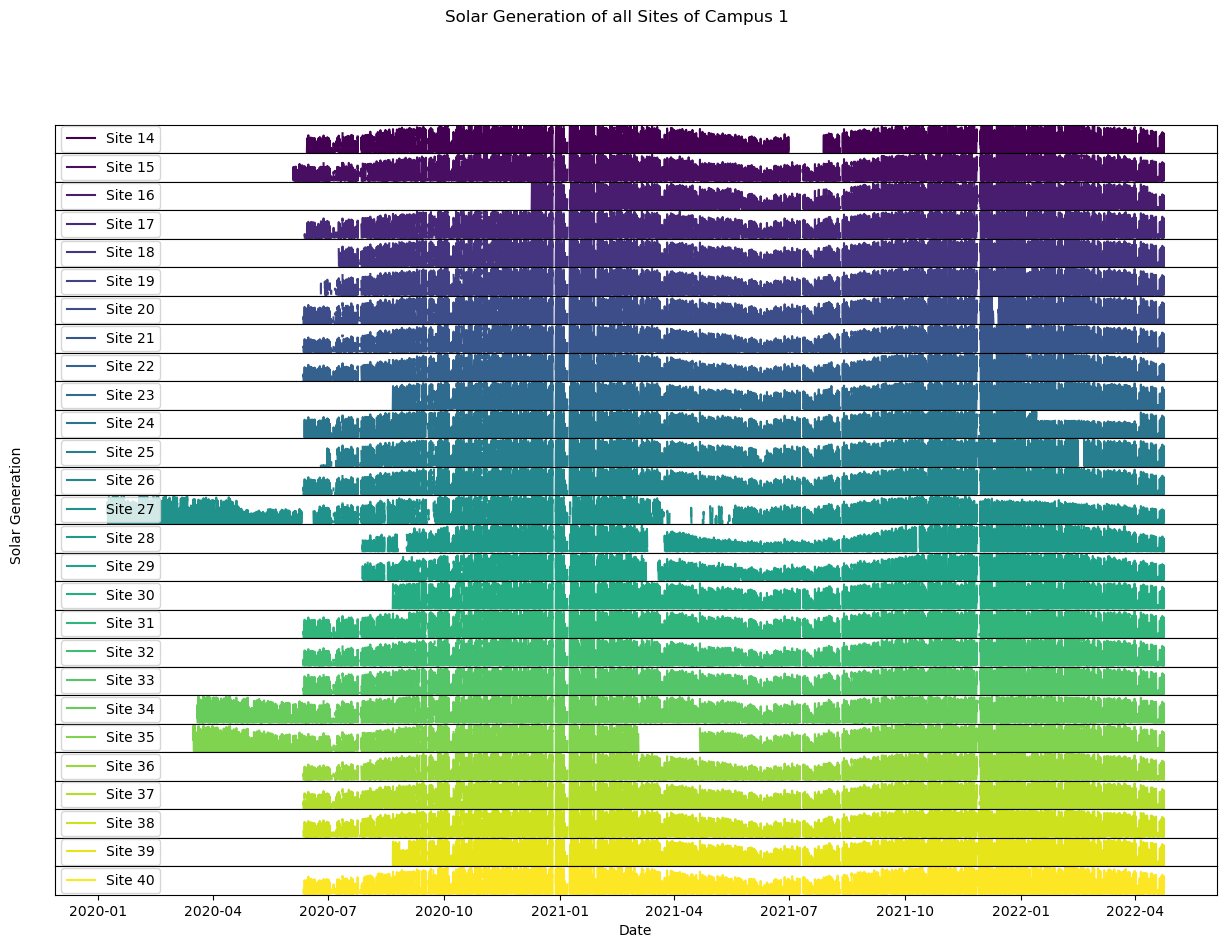

In [72]:
campus_number = 1
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 10, 'Solar Generation of all Sites of Campus 1')

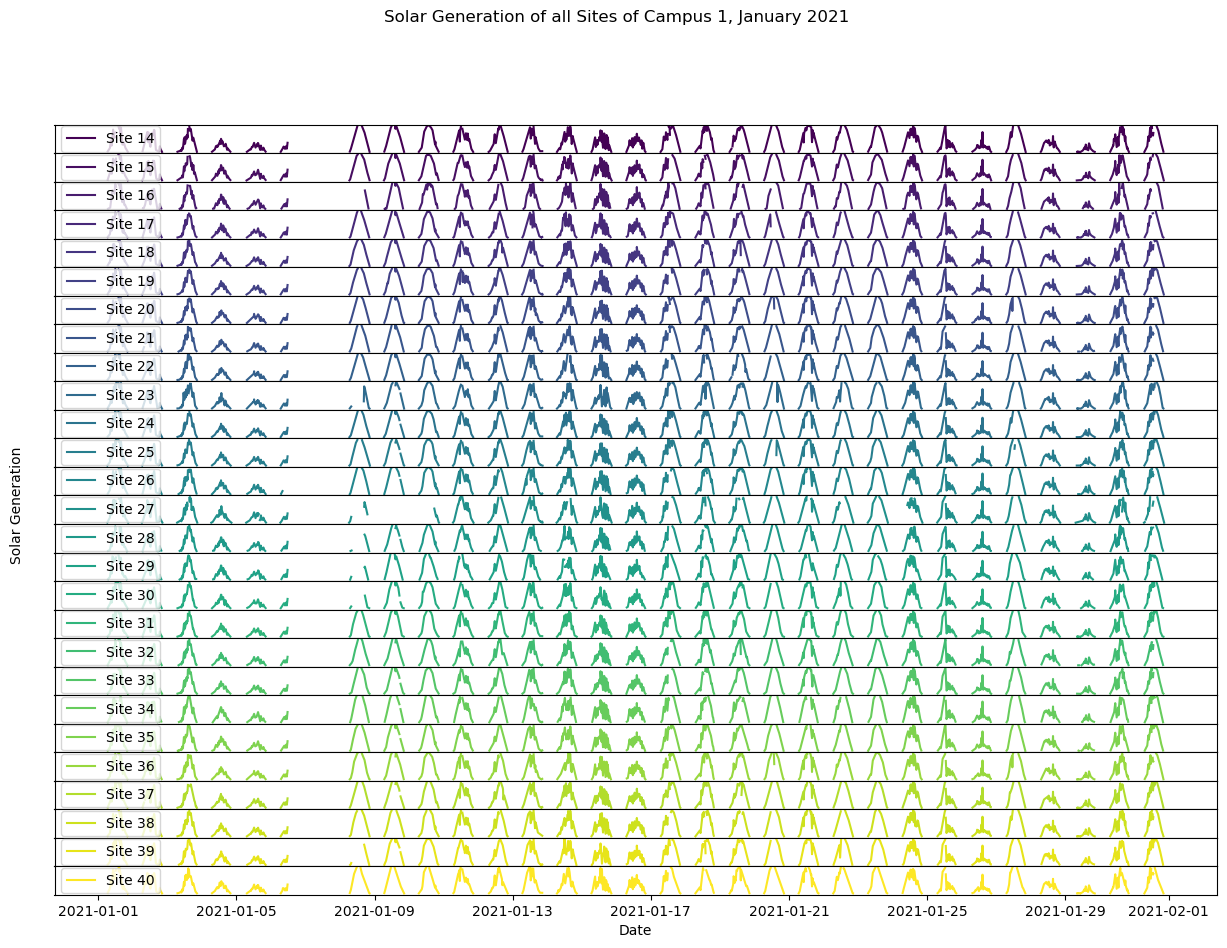

In [73]:
plot_solar_generation_sites(df_power.loc['2021-01'], sites_in_campus[campus_number], 10, 'Solar Generation of all Sites of Campus 1, January 2021')

#### For Campus 2

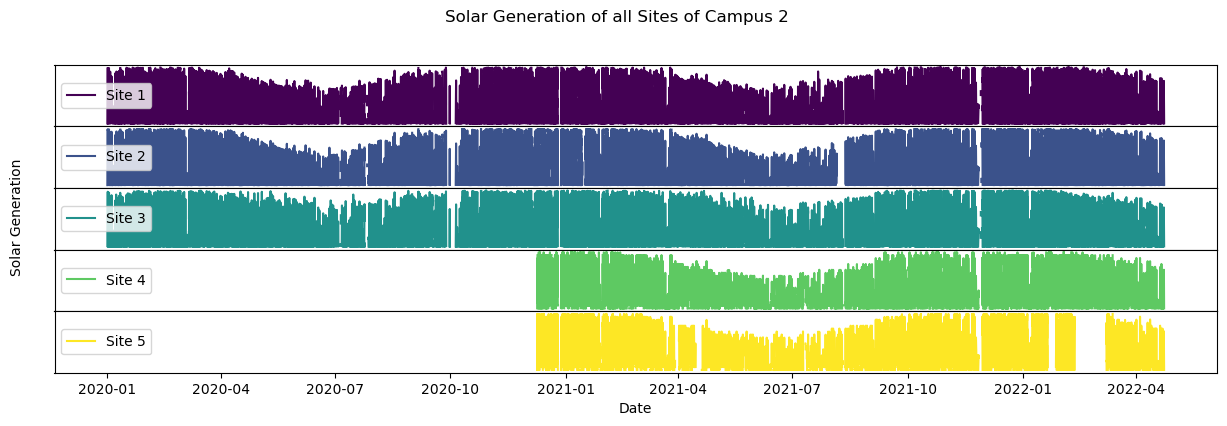

In [74]:
campus_number = 2
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 4, 'Solar Generation of all Sites of Campus 2')

#### For Campus 3

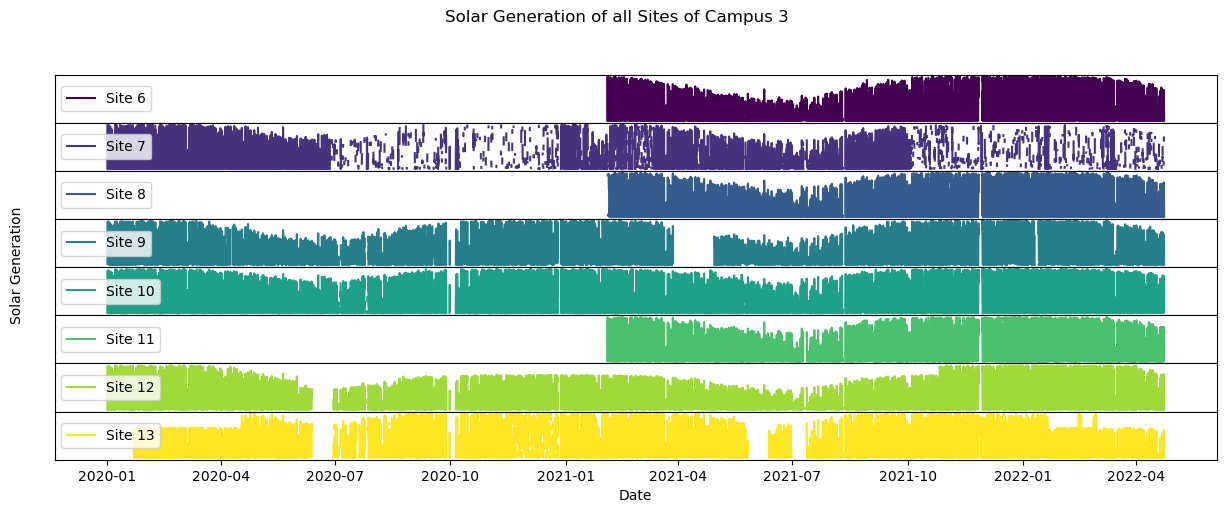

In [75]:
campus_number = 3
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 5, 'Solar Generation of all Sites of Campus 3')

#### For Campus 4

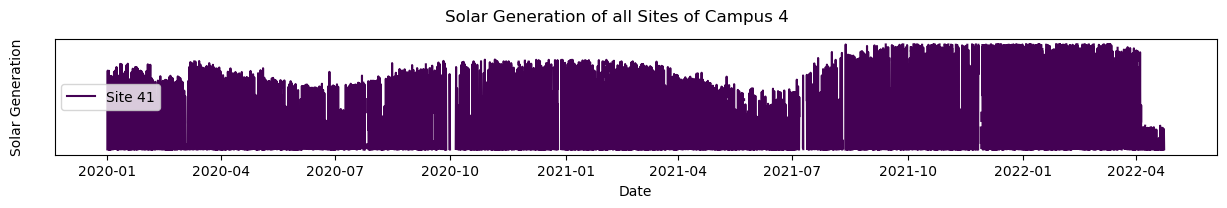

In [76]:
campus_number = 4
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 1.5, 'Solar Generation of all Sites of Campus 4')

#### And Campus 5

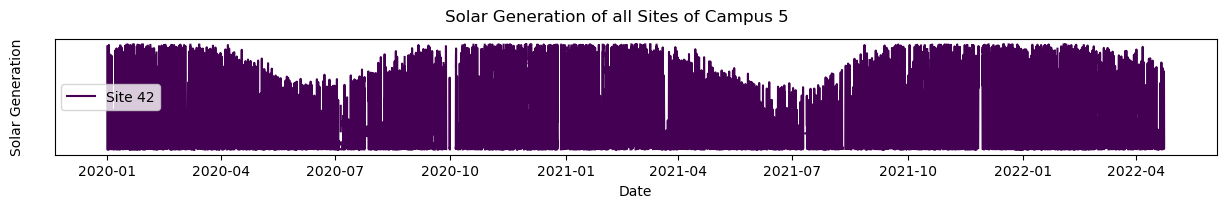

In [77]:
campus_number = 5
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 1.5, 'Solar Generation of all Sites of Campus 5')

We can make three observations after looking at these five plots:
- Origin of missing data. It seems that some sites were deployed later than others, resulting in missing data for extended periods of time. We also observe smaller intervals without data that are sometimes shared between different sites and may be due to technical issues. In addition, we see that `SolarGeneration` values below a certain thresholds are filled with NaN.
- There seems to be a substantial correlation between `SolarGeneration` of the different sites belonging to the same campus. Asides from missing data, sites plots for a given campus look close to identical in relative units.
- The `SolarGeneration` from the different campus are similar in terms of seasonality, be we observed difference, for instance in the location of the minimum power generation.

### Solar Generation Correlation
---

We can check the correlation `SolarGeneration` between sites of a given campus.
Campus 2 and 3 have a site numbers small enough so we can plot correlation heatmaps.

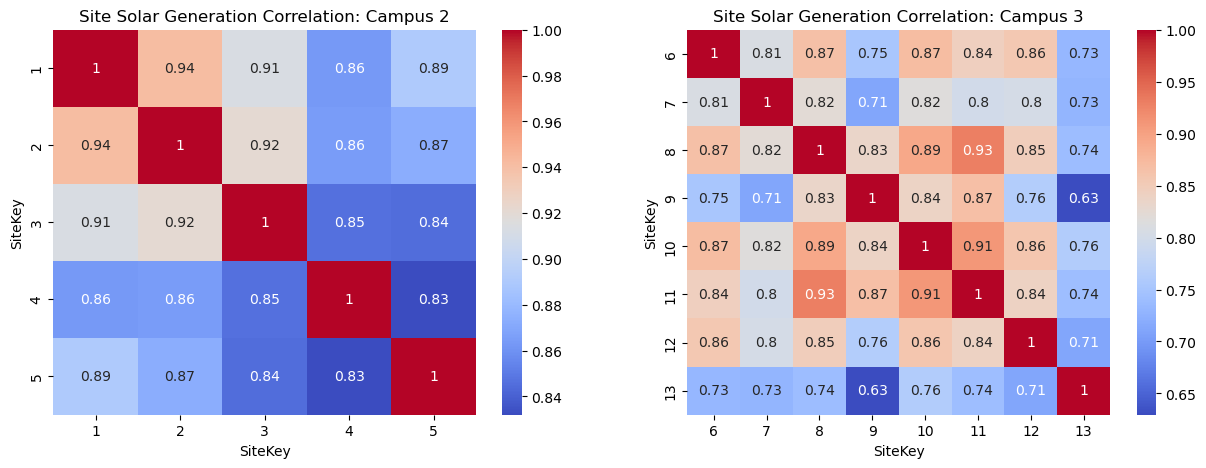

In [78]:
fig,axs = plt.subplots(1, 2, figsize=(15, 5))
for i, campus in enumerate([2, 3]):
    sns.heatmap(
        df_power[sites_in_campus[campus]].corr(method='kendall'),
        annot=True, cmap='coolwarm', ax=axs[i]
    )
    axs[i].set_title(f'Site Solar Generation Correlation: Campus {campus}');

The number of sites in campus 1 is too large to plot a heatmap, but we can find the lowest coefficient of correlation for all sites in campus 1:

In [79]:
print('Lowest site Solar Generation correlation coefficient for campus 1:',
       np.round(df_power[sites_in_campus[1]].corr().min(axis=None), 2)
)

Lowest site Solar Generation correlation coefficient for campus 1: 0.89


The lowest correlation coefficient between sites of campus 1 is large.

Campus 4 and 5 only have one site each.

Overall, the correlation coefficients of `SolarGeneration` between sites for each campus is typically above 0.8. We will assume that each site is representative of its whole campus. To simplify our forecasting task, we will pick one site per campus. To decide which site to pick as a representative site, we will take a closer look at the missing data.

### Missing Values and Representative Sites
---

For each campus, we could pick the site which has the fewest missing values. Below we show the 5 sites with the fewest missing values for each campus.

In [80]:
df_power[sites_in_campus[1]].isna().sum().sort_values().head(5)

SiteKey
27    45873
34    50648
15    51475
35    51790
24    51833
dtype: int64

Site 27 has fewer missing entries because its record starts earlier, but it has several large gaps with no data. We will pick site 34 instead.

In [81]:
df_power[sites_in_campus[2]].isna().sum().sort_values().head()

SiteKey
1    43450
2    44258
3    44385
4    61546
5    63054
dtype: int64

In [82]:
df_power[sites_in_campus[3]].isna().sum().sort_values().head()

SiteKey
10    44575
12    44935
13    49393
9     50029
11    60694
dtype: int64

Sites number 27, 1, 10, 41, 42 are selected as representative of campus 1, 2, 3, 4 and 5, respectively.

In [83]:
selected_sites = [34, 1, 10, 41, 42]

We can now compare the selected sites.

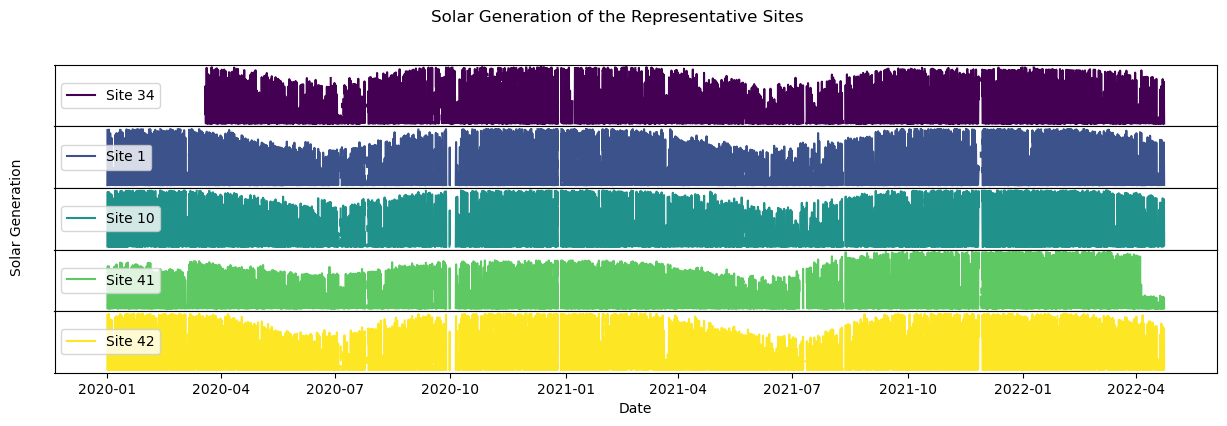

In [84]:
plot_solar_generation_sites(df_power, selected_sites, 4, 'Solar Generation of the Representative Sites')

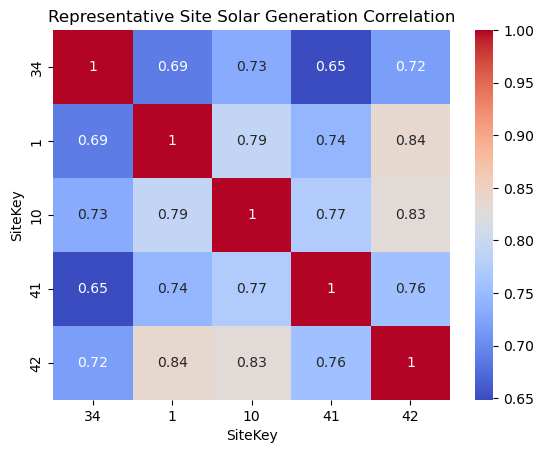

In [85]:
fig,axs = plt.subplots(1, 1)
sns.heatmap(df_power[selected_sites].corr(),
            annot=True, cmap='coolwarm', ax=axs)
axs.set_title(f'Representative Site Solar Generation Correlation');

As could be inferred by looking at the different time series, the correlation between sites of different campuses if lower than correlation between sites of the same campus. This makes sens, as different locations may be subject to different weather conditions.

Looking at a smaller time window, we observe that the majority of missing data are between solar generation period, *i.e.* at night. There are also missing data during the day, but they are far less common and sometimes shared between sites, maybe due to technical problem of serious weather event obliterating solar generation.

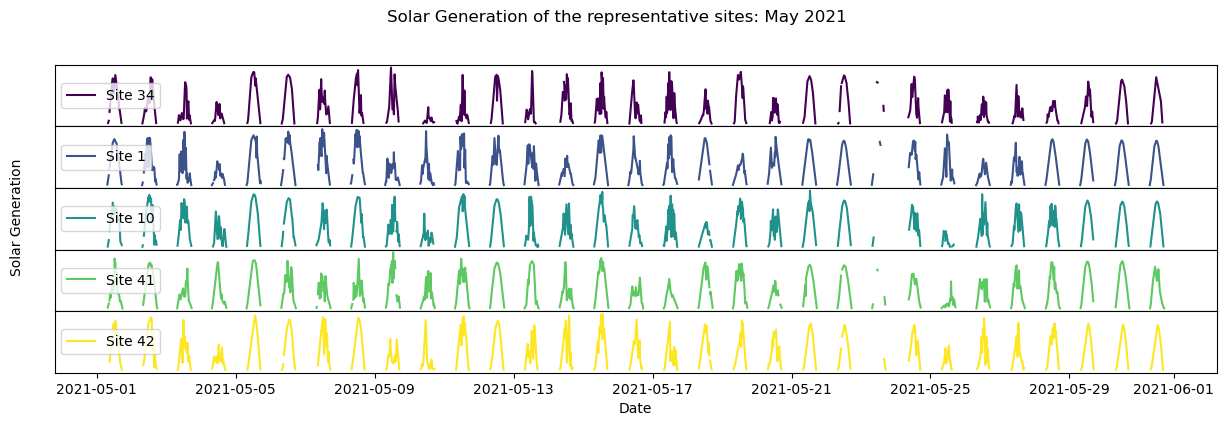

In [86]:
plot_solar_generation_sites(df_power.loc[pd.Timestamp('2021-05'):pd.Timestamp('2021-06')],
                             selected_sites, 4, 'Solar Generation of the representative sites: May 2021')

Assuming the systems return `Nan` when `SolarGeneration` is smaller than a threshold power, it is possible that some daytime missing values are due to weather events leading the power generation to drop close to zer. Without better understanding of what exactly triggers the generation of NaN, it is safest to fill missing values with `0`.

In [87]:
df_power = df_power.fillna(0)

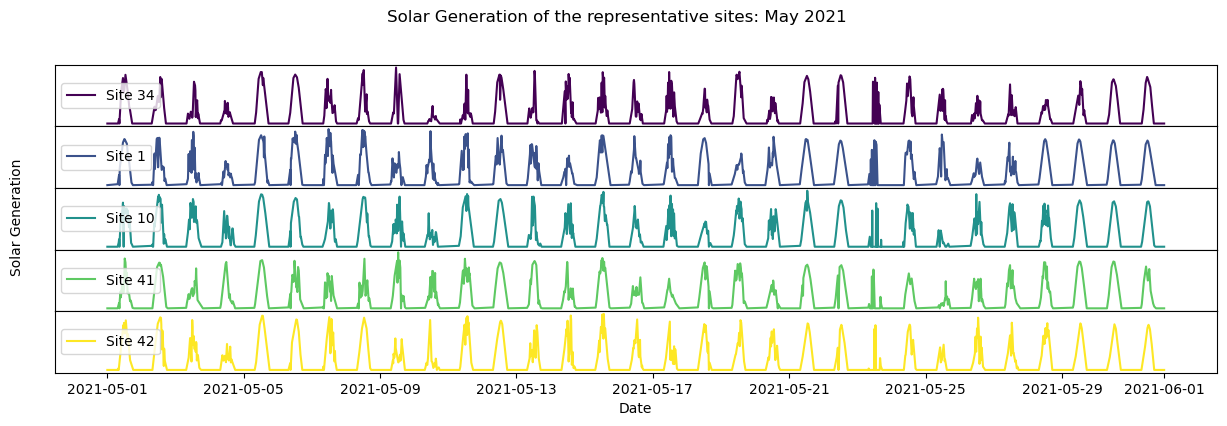

In [88]:
plot_solar_generation_sites(df_power.loc[pd.Timestamp('2021-05'):pd.Timestamp('2021-06')],
                             selected_sites, 4, 'Solar Generation of the representative sites: May 2021')

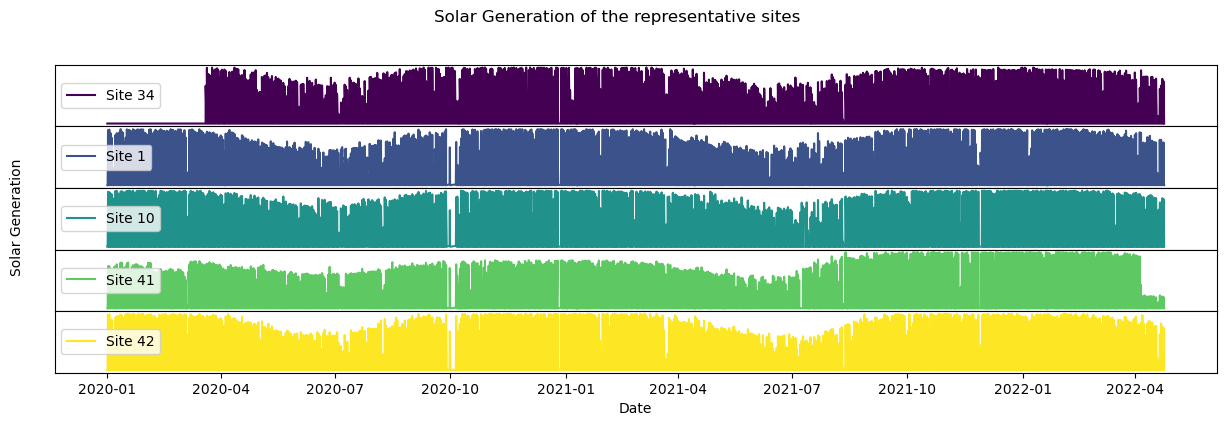

In [89]:
plot_solar_generation_sites(df_power, selected_sites, 4, 'Solar Generation of the representative sites')

We have identified  a subset of data to study and we have dataframe with no missing values.

## Exploratory Data Analysis: Weather

---

Now, let's look at the weather data for each campus.

In [90]:
df_weather = pd.read_csv(weather_path, parse_dates=['Timestamp'])
df_weather['CampusKey'] = df_weather['CampusKey'].astype('int8')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371769 entries, 0 to 371768
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CampusKey            371769 non-null  int8          
 1   Timestamp            371769 non-null  datetime64[ns]
 2   ApparentTemperature  264656 non-null  float64       
 3   AirTemperature       264656 non-null  float64       
 4   DewPointTemperature  264656 non-null  float64       
 5   RelativeHumidity     264656 non-null  float64       
 6   WindSpeed            208879 non-null  float64       
 7   WindDirection        208879 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int8(1)
memory usage: 20.2 MB


In [91]:
df_weather.head()

,CampusKey,Timestamp,ApparentTemperature,AirTemperature,DewPointTemperature,RelativeHumidity,WindSpeed,WindDirection
0,1,2020-01-01 00:00:00,13.666667,13.880000,8.960000,72.400000,0.000000,188.133333
1,1,2020-01-01 00:15:00,13.206667,13.666667,9.040000,73.466667,1.200000,203.866667
2,1,2020-01-01 00:30:00,12.840000,13.553333,9.053333,74.000000,2.520000,222.800000
3,1,2020-01-01 00:45:00,12.113333,13.506667,9.100000,74.466667,5.986667,231.133333
4,1,2020-01-01 01:00:00,11.946667,13.260000,9.266667,76.533333,5.946667,247.866667


`df_weather` contains weather information for each campus stored as time series. `DewPointTemperature` and `ApparentTemperature` are both calculated using on `AirTemperature` and `RelativeHumidity`. We will drop these two columns for now as they don't add new information.

In [92]:
df_weather = df_weather.drop(columns=['ApparentTemperature','DewPointTemperature'])

### Distribution
---

We can take a look at the distribution of the weather features for the different campus locations.

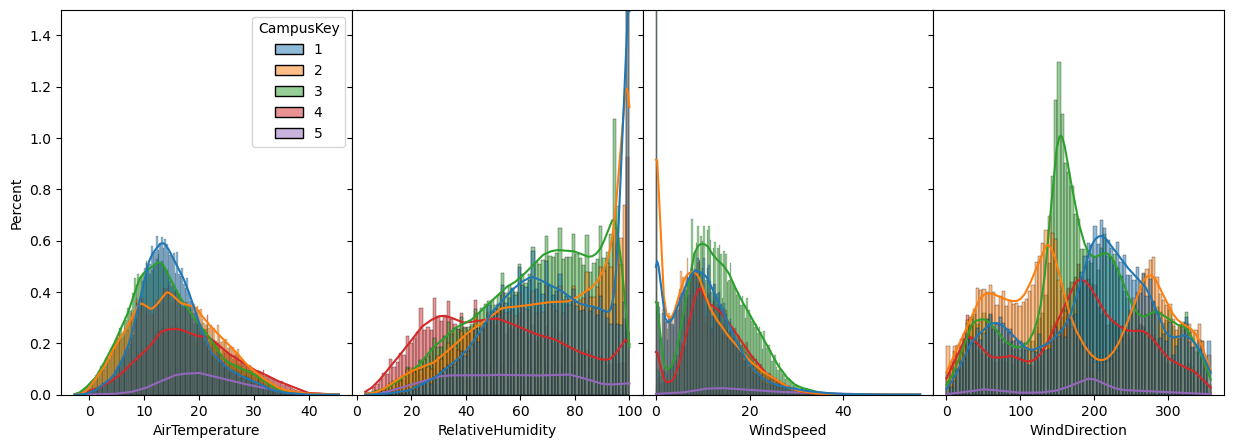

In [93]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
for i, columns in enumerate(['AirTemperature', 'RelativeHumidity', 'WindSpeed', 'WindDirection']):
    sns.histplot(df_weather, x=columns, hue='CampusKey', palette='tab10', ax=axs[i], legend=i==0, multiple='layer', stat='percent', kde=True)
axs[-1].set_ylim(0, 1.5)
fig.subplots_adjust(wspace=0)

As can be seen from these histograms, the distributions of the different weather parameters vary significantly between the different campus locations. These variable don't seem to be normally distributed.

### Weather Data Time Series
---

As for the solar generation data, pivoting the dataframe will make the analysis easier.

In [94]:
df_weather = df_weather.pivot(index='Timestamp', columns='CampusKey', values = ['AirTemperature','RelativeHumidity', 'WindSpeed', 'WindDirection']) 

In [95]:
df_weather.head()

AirTemperature                                       \
CampusKey                        1          2          3          4   5   
Timestamp                                                                 
2020-01-01 00:00:00      13.880000  20.140000  14.180000  21.620000 NaN   
2020-01-01 00:15:00      13.666667  20.300000  13.860000  21.246667 NaN   
2020-01-01 00:30:00      13.553333  19.840000  13.593333  20.940000 NaN   
2020-01-01 00:45:00      13.506667  19.886667  13.400000  20.633333 NaN   
2020-01-01 01:00:00      13.260000  19.540000  13.193333  20.400000 NaN   

                    RelativeHumidity                                       \
CampusKey                          1          2          3          4   5   
Timestamp                                                                   
2020-01-01 00:00:00        72.400000  49.200000  49.600000  24.800000 NaN   
2020-01-01 00:15:00        73.466667  50.266667  50.200000  26.266667 NaN   
2020-01-01 00:30:00        74.000000  50.666667  51.600000  27.533333 NaN   
2020-01-01 00:45:00        74.466667  51.000000  53.000000  28.800000 NaN   
2020-01-01 01:00:00        76.533333  51.133333  54.866667  29.933333 NaN   

                    WindSpeed                              WindDirection  \
CampusKey                   1          2      3      4   5             1   
Timestamp                                                                  
2020-01-01 00:00:00  0.000000  10.120000  14.32  17.28 NaN    188.133333   
2020-01-01 00:15:00  1.200000   8.680000  15.28  16.14 NaN    203.866667   
2020-01-01 00:30:00  2.520000   7.933333  13.60  16.86 NaN    222.800000   
2020-01-01 00:45:00  5.986667   8.440000  12.88  17.10 NaN    231.133333   
2020-01-01 01:00:00  5.946667   8.680000  13.60  18.72 NaN    247.866667   

                                                             
CampusKey                     2           3           4   5  
Timestamp                                                    
2020-01-01 00:00:00  180.666667  153.600000  206.733333 NaN  
2020-01-01 00:15:00  152.666667  158.666667  204.000000 NaN  
2020-01-01 00:30:00  157.533333  156.600000  200.866667 NaN  
2020-01-01 00:45:00  147.600000  148.533333  200.866667 NaN  
2020-01-01 01:00:00  151.333333  164.733333  197.066667 NaN

Before we go further, we will check if the timestamp index is sorted and make sure it is evenly spaced.

In [96]:
df_weather.index.is_monotonic_increasing

True

In [97]:
time_series_idx = pd.pandas.date_range(min(df_weather.index), max(df_weather.index),freq='15min')
df_weather = df_weather.reindex(time_series_idx, fill_value=np.nan)
df_weather.index.name = 'Timestamp'

Now we can individually look at all weather features as a function of time for each campuses. We will also report the number of non-missing entries.

Campus 1: 66222 non-null data
Campus 2: 68254 non-null data
Campus 3: 72275 non-null data
Campus 4: 45595 non-null data
Campus 5: 12310 non-null data


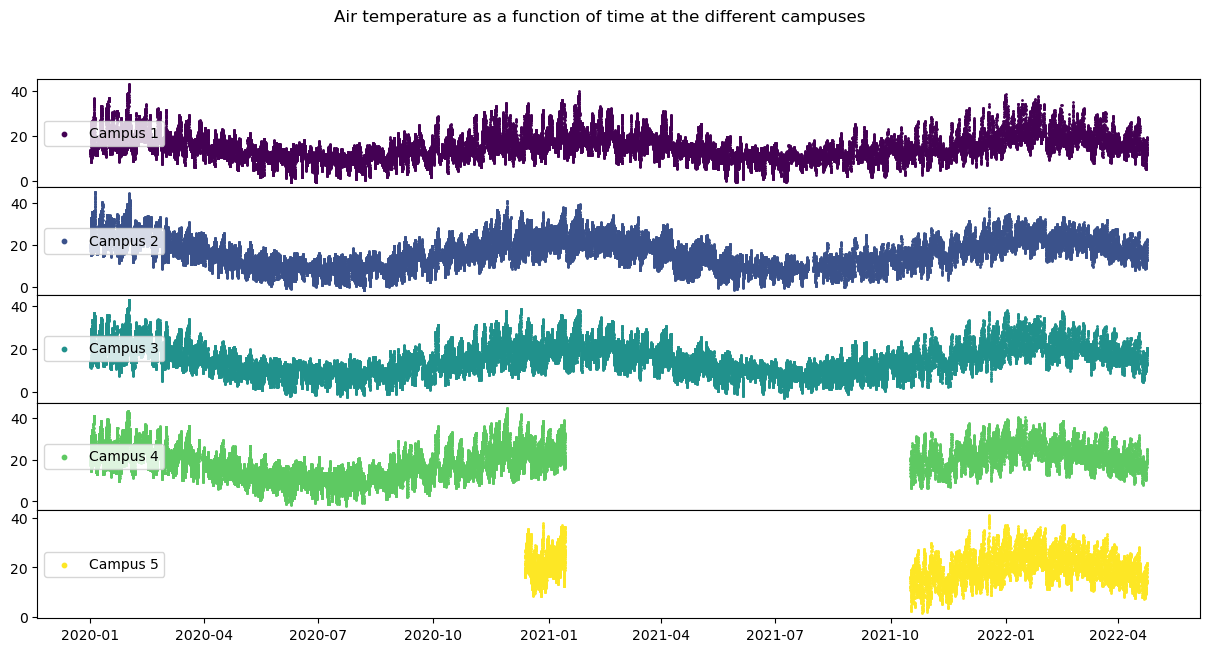

In [98]:
plot_weather_feature_campuses(df_weather, ['AirTemperature'], sites_in_campus.index, 'Air temperature as a function of time at the different campuses')

We are missing a big part of the `AirTemperature` data for site campus 4, and almost of the data for campus 5. Overall, the curves look similar.

Campus 1: 66222 non-null data
Campus 2: 68254 non-null data
Campus 3: 72275 non-null data
Campus 4: 45595 non-null data
Campus 5: 12310 non-null data


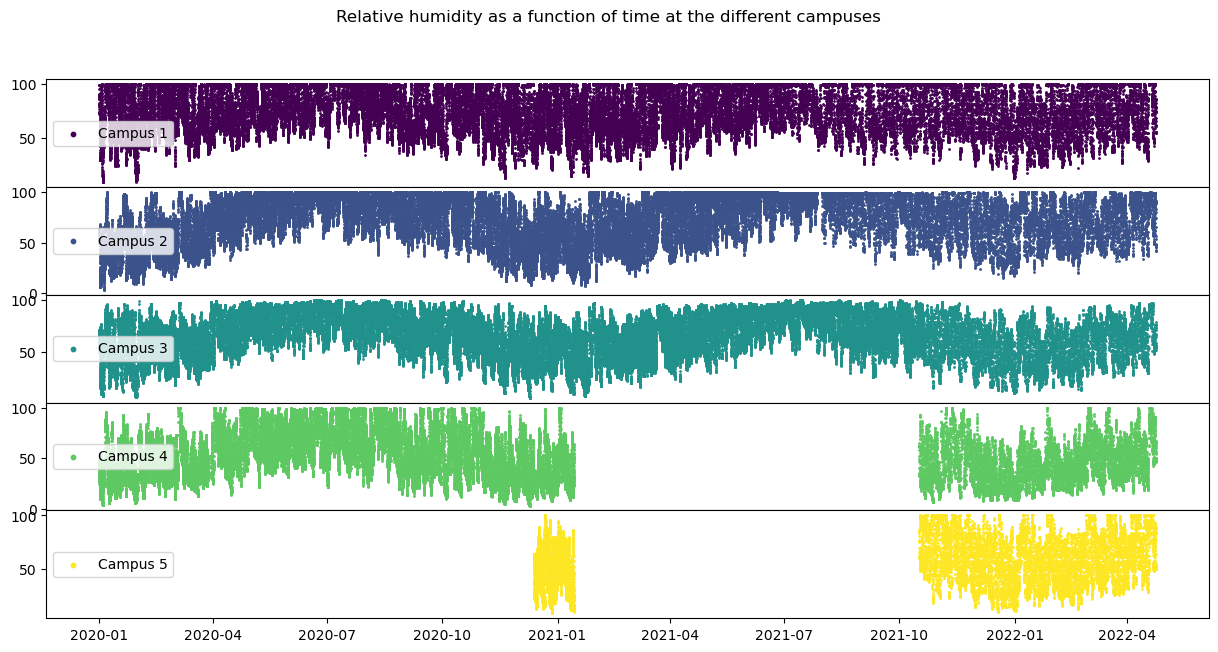

In [99]:
plot_weather_feature_campuses(df_weather, ['RelativeHumidity'], sites_in_campus.index, 'Relative humidity as a function of time at the different campuses')

Large amount of missing data as well for `RelativeHumidity` at campus 5. We can clearly see the different types of weather with the fraction of data at 100% relative humidity.

Campus 1: 51327 non-null data
Campus 2: 54975 non-null data
Campus 3: 63139 non-null data
Campus 4: 36355 non-null data
Campus 5: 3083 non-null data


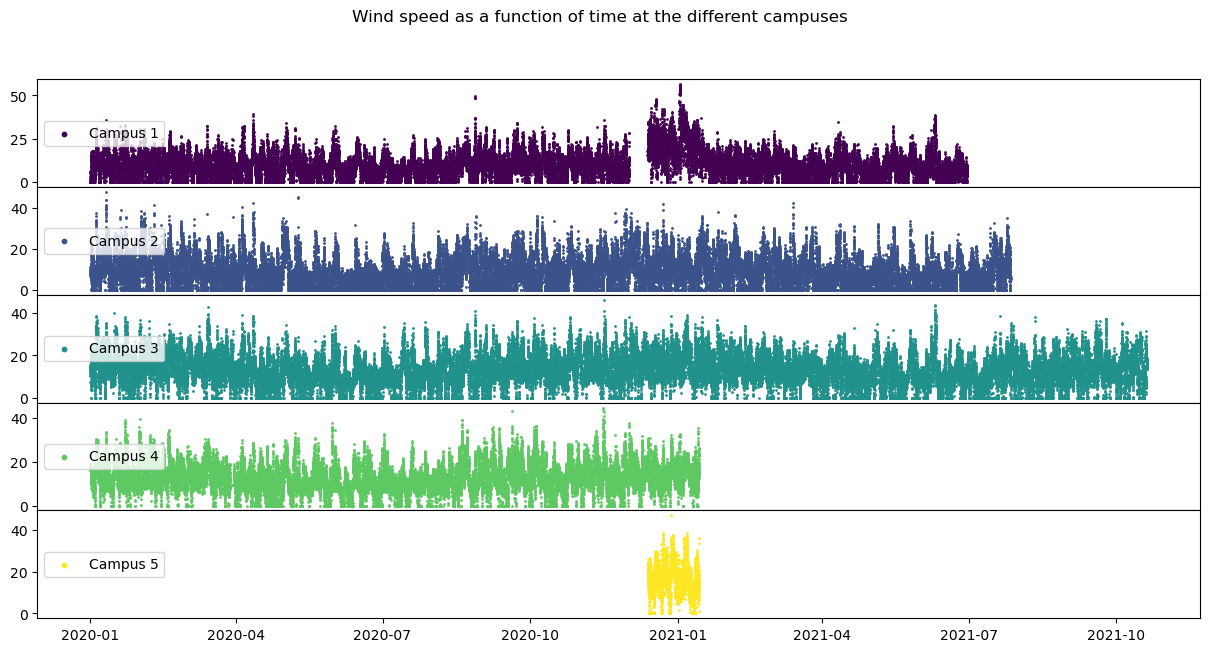

In [100]:
plot_weather_feature_campuses(df_weather, ['WindSpeed'], sites_in_campus.index, 'Wind speed as a function of time at the different campuses')

Again, many missing entries for campus 5. Campus 3 seems to have the largest number of entries.

Campus 1: 51327 non-null data
Campus 2: 54975 non-null data
Campus 3: 63139 non-null data
Campus 4: 36355 non-null data
Campus 5: 3083 non-null data


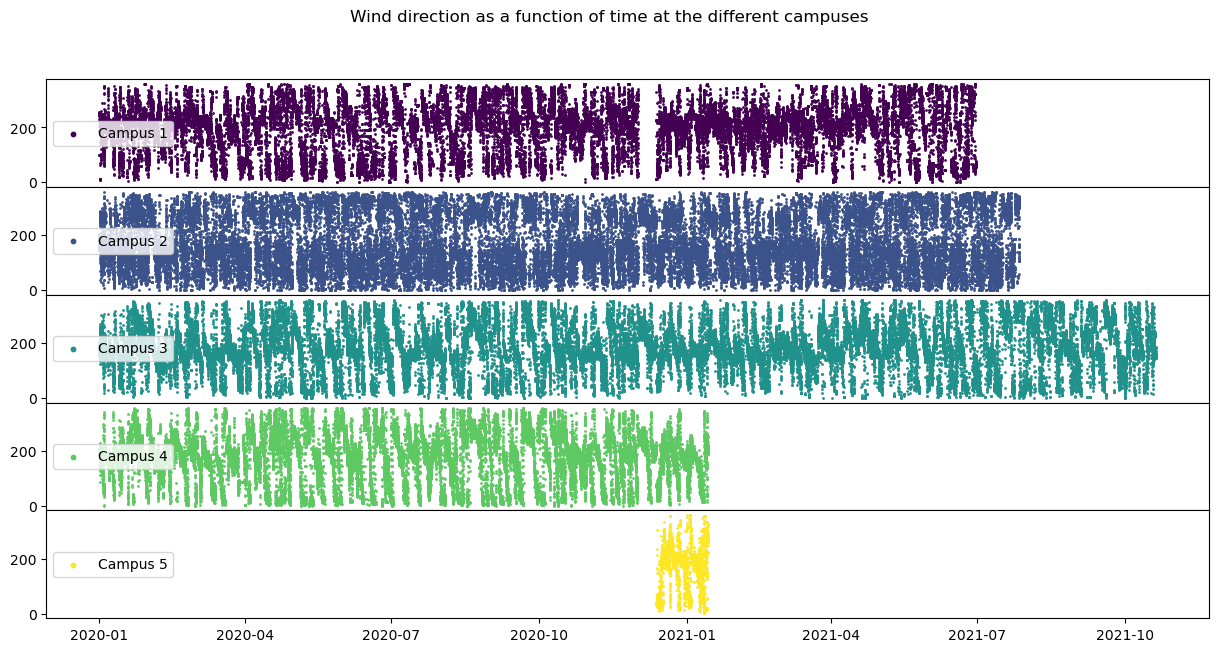

In [101]:
plot_weather_feature_campuses(df_weather, ['WindDirection'], sites_in_campus.index, 'Wind direction as a function of time at the different campuses')

We see that `WindDirection` is encoded as an angle between 0 and 360 degrees. It will make more sense encode this feature as a vector in the model notebook.

Let's take a look at the correlation heatmap between all the weather parameters at the different sites to see if there is any information redundancy.

### Weather Data Correlations

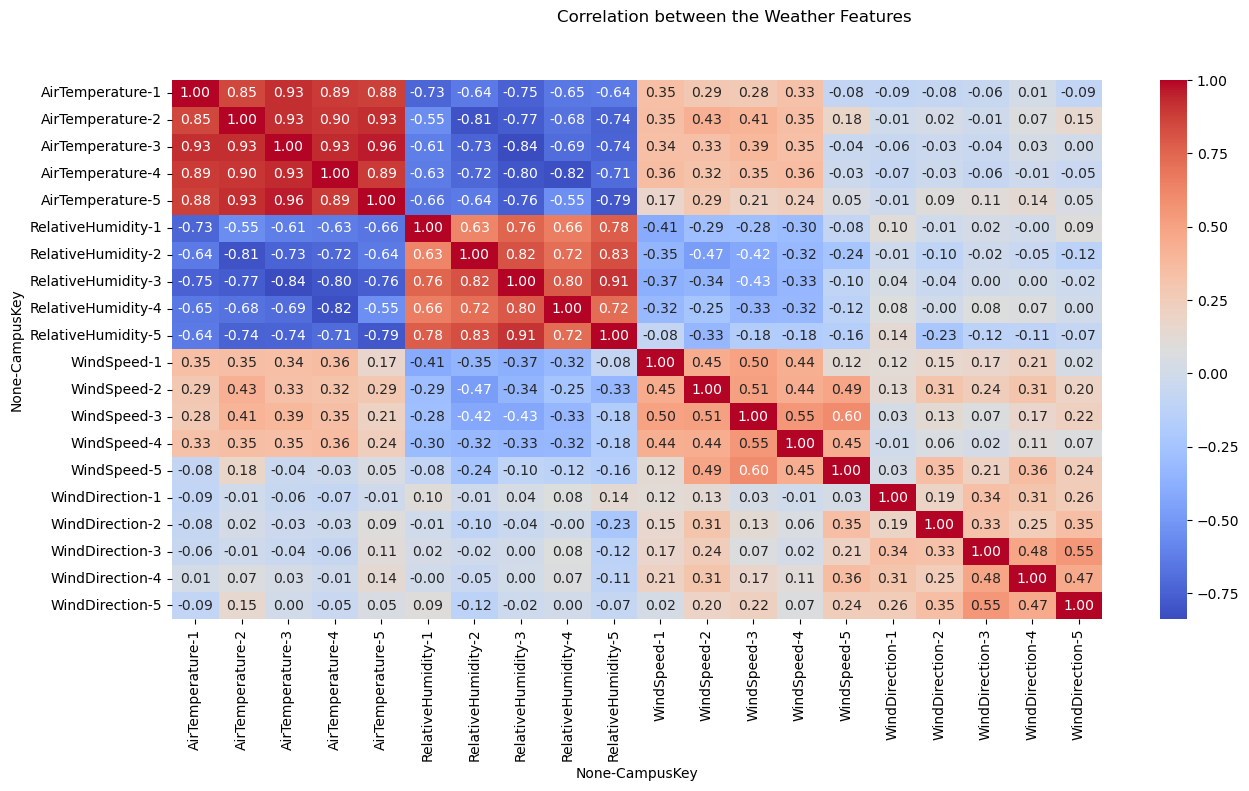

In [102]:
fig, ax = plt.subplots(1, figsize=(15,7))
sns.heatmap(df_weather.corr(), cmap='coolwarm', annot=True, fmt='.2f')
fig.suptitle('Correlation between the Weather Features');

We observe a significant correlation between different campuses for a given weather feature. We also see that the correlation between `AirTemperature` and `Relative Humidity` is a substantial. They are also correlated to `WindSpeed` to a lesser extent. `Wind direction` is only weakly correlated to `WindSpeed`.

Campus 3 had by far the smallest number of missing entries. We will restrict our analysis to this one for now. We create a new dataframe `df_weather_campus3` containing weather data for campus 3 only, and will work on missing data on the subset of the weather data for now.

In [103]:
df_weather_campus3 = df_weather.xs(axis=1, level=1, key=3)

### Missing data

In [104]:
df_weather_campus3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81017 entries, 2020-01-01 00:00:00 to 2022-04-23 22:00:00
Freq: 15T
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AirTemperature    72275 non-null  float64
 1   RelativeHumidity  72275 non-null  float64
 2   WindSpeed         63139 non-null  float64
 3   WindDirection     63139 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


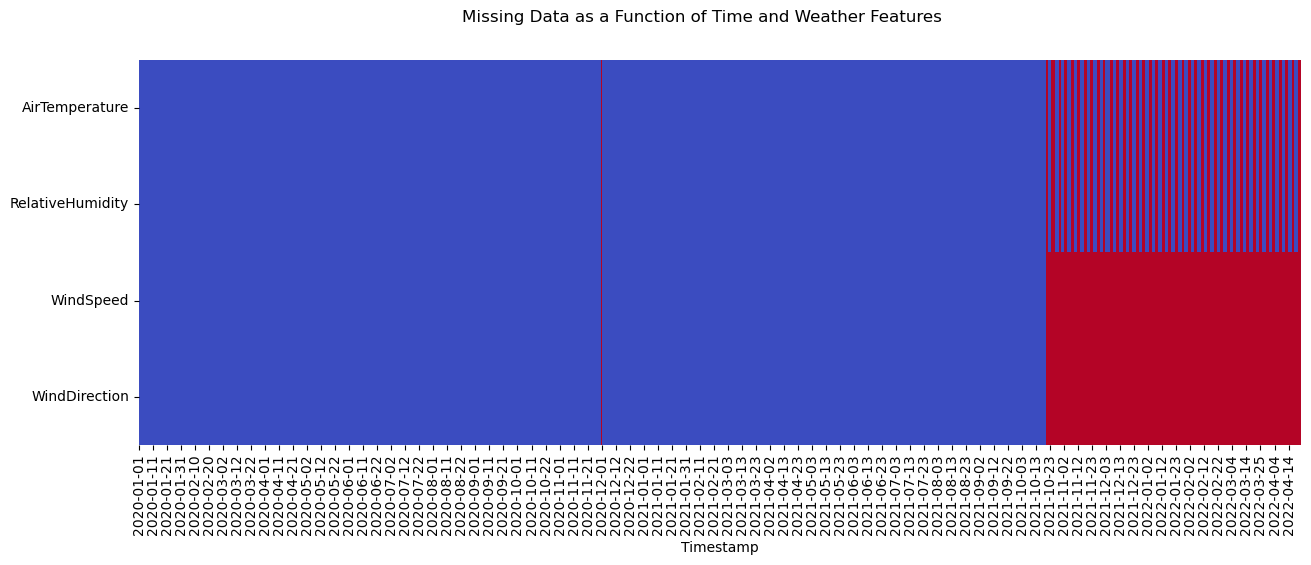

In [105]:
fig, axs = plt.subplots(1, figsize=(15, 5))
axs = sns.heatmap(df_weather_campus3.isna().T, cmap='coolwarm', cbar=False)
# date_form = DateFormatter("%D")  # hour without zero padding
# axs.xaxis.set_major_formatter(date_form)

ticklabels = [df_weather_campus3.index[int(tick)].strftime('%Y-%m-%d') for tick in axs.get_xticks()]
axs.set_xticklabels(ticklabels)

fig.suptitle('Missing Data as a Function of Time and Weather Features');

In [106]:
df_weather_campus3.query('Timestamp<"2021-10"').isnull().sum()

AirTemperature      44
RelativeHumidity    44
WindSpeed           44
WindDirection       44
dtype: int64

Most of the missing data for campus 3 are located after 2021-10. Before that date, there were only a few (44) missing entries, representing less than 0.1% of the data. After 2021-10, there are between over 44% and 90% of missing data:

In [107]:
df_weather_campus3.query('Timestamp>"2021-10"').isna().sum()/len(df_weather_campus3.query('Timestamp>"2021-10"'))*100

AirTemperature      44.215128
RelativeHumidity    44.215128
WindSpeed           90.656771
WindDirection       90.656771
dtype: float64

## Merging datasets

Since we restricted our analysis to campus 3 and saw we could use a single site as representative of a campus, we can combine the weather dataframe from campus 3 with the solar generation data from the representative site 10. We will only use data recorded before October 2021 as there are too many missing weather data after that date.

In [108]:
df_preprocess = pd.merge(df_power[[10]], df_weather_campus3, how = 'left', on='Timestamp')
df_preprocess = df_preprocess.rename(columns={10: 'SolarGeneration'})
df_preprocess = df_preprocess.query('Timestamp<"2021-10"')

In [109]:
df_preprocess.head()

,SolarGeneration,AirTemperature,RelativeHumidity,WindSpeed,WindDirection
Timestamp,,,,,
2020-01-01 00:15:00,0.0,13.860000,50.200000,15.28,158.666667
2020-01-01 00:30:00,0.0,13.593333,51.600000,13.60,156.600000
2020-01-01 00:45:00,0.0,13.400000,53.000000,12.88,148.533333
2020-01-01 01:00:00,0.0,13.193333,54.866667,13.60,164.733333
2020-01-01 01:15:00,0.0,13.200000,56.200000,14.80,168.000000


In [110]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61343 entries, 2020-01-01 00:15:00 to 2021-09-30 23:45:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   61343 non-null  float64
 1   AirTemperature    61299 non-null  float64
 2   RelativeHumidity  61299 non-null  float64
 3   WindSpeed         61299 non-null  float64
 4   WindDirection     61299 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


We can find the location of the 44 missing weather entries:

In [111]:
df_preprocess[df_preprocess.isna().any(axis=1)].index

DatetimeIndex(['2020-10-04 02:00:00', '2020-10-04 02:15:00',
               '2020-10-04 02:30:00', '2020-10-04 02:45:00',
               '2020-12-01 14:00:00', '2020-12-01 14:15:00',
               '2020-12-01 14:30:00', '2020-12-01 14:45:00',
               '2020-12-01 15:00:00', '2020-12-01 15:15:00',
               '2020-12-01 15:30:00', '2020-12-01 15:45:00',
               '2020-12-01 16:00:00', '2020-12-01 16:15:00',
               '2020-12-01 16:30:00', '2020-12-01 16:45:00',
               '2020-12-01 17:00:00', '2020-12-01 17:15:00',
               '2020-12-01 17:30:00', '2020-12-01 17:45:00',
               '2020-12-01 18:00:00', '2020-12-01 18:15:00',
               '2020-12-01 18:30:00', '2020-12-01 18:45:00',
               '2020-12-01 19:00:00', '2020-12-01 19:15:00',
               '2020-12-01 19:30:00', '2020-12-01 19:45:00',
               '2020-12-01 20:00:00', '2020-12-01 20:15:00',
               '2020-12-01 20:30:00', '2020-12-01 20:45:00',
               '2020-12-

We only have missing data for two days. We can fill in the missing entries with the forward filling method.

In [112]:
df_preprocess = df_preprocess.ffill()

We now have a full dataset to train our model on.

In [113]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61343 entries, 2020-01-01 00:15:00 to 2021-09-30 23:45:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   61343 non-null  float64
 1   AirTemperature    61343 non-null  float64
 2   RelativeHumidity  61343 non-null  float64
 3   WindSpeed         61343 non-null  float64
 4   WindDirection     61343 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


## Saving Data

We save the preprocessed data to `preprocessed_data.csv`.

In [114]:
df_preprocess.to_csv('preprocessed_data.csv')

The next notebook `unisolar_model.ipynb` will present the feature engineering and modeling par of the project.